In [89]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [90]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("oleksiimartusiuk/bts-january-2024-commercial-flights-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/bts-january-2024-commercial-flights-data


In [91]:
df = pd.read_csv(path + "/T_ONTIME_MARKETING.csv")

<ipython-input-91-330a750163a4>:1: DtypeWarning: Columns (40,44,45,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + "/T_ONTIME_MARKETING.csv")


In [92]:
null_percentages = (df.isnull().sum() / len(df)) * 100
columns_to_drop = null_percentages[null_percentages > 10].index
df = df.drop(columns=columns_to_drop)
df = df.drop(columns=['DIVERTED','ARR_DELAY', 'TAIL_NUM', 'OP_UNIQUE_CARRIER', 'ORIGIN_CITY_MARKET_ID', 'DEST_CITY_MARKET_ID', 'TAXI_OUT','TAXI_IN','WHEELS_OFF', 'WHEELS_ON','DUP', 'DIVERTED', 'DIV_AIRPORT_LANDINGS', 'OP_CARRIER_FL_NUM'])
df.head(10)

,FL_DATE,MKT_UNIQUE_CARRIER,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST_CITY_NAME,DEST_STATE_ABR,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY_NEW,CANCELLED,DISTANCE
0,1/1/2024 12:00:00 AM,AA,"New York, NY",NY,"Los Angeles, CA",CA,900,852.0,-8.0,1124.0,0.0,0.0,2475.0
1,1/1/2024 12:00:00 AM,AA,"Los Angeles, CA",CA,"New York, NY",NY,1235,1232.0,-3.0,2107.0,8.0,0.0,2475.0
2,1/1/2024 12:00:00 AM,AA,"Boston, MA",MA,"Los Angeles, CA",CA,1800,1754.0,-6.0,2041.0,0.0,0.0,2611.0
3,1/1/2024 12:00:00 AM,AA,"Los Angeles, CA",CA,"Boston, MA",MA,750,742.0,-8.0,1638.0,19.0,0.0,2611.0
4,1/1/2024 12:00:00 AM,AA,"Phoenix, AZ",AZ,"Portland, OR",OR,1502,1458.0,-4.0,1654.0,0.0,0.0,1009.0
5,1/1/2024 12:00:00 AM,AA,"Portland, OR",OR,"Phoenix, AZ",AZ,1815,1815.0,0.0,2139.0,0.0,0.0,1009.0
6,1/1/2024 12:00:00 AM,AA,"Denver, CO",CO,"Phoenix, AZ",AZ,1206,1204.0,-2.0,1355.0,0.0,0.0,602.0
7,1/1/2024 12:00:00 AM,AA,"Phoenix, AZ",AZ,"Denver, CO",CO,930,926.0,-4.0,1110.0,0.0,0.0,602.0
8,1/1/2024 12:00:00 AM,AA,"Portland, OR",OR,"Phoenix, AZ",AZ,508,503.0,-5.0,838.0,0.0,0.0,1009.0
9,1/1/2024 12:00:00 AM,AA,"New York, NY",NY,"Santa Ana, CA",CA,830,825.0,-5.0,1118.0,0.0,0.0,2454.0


In [93]:
# 0: on time
df.loc[:, 'target'] = 0
# 1: delayed
df.loc[(df['ARR_DELAY_NEW'] > 15) & (df['CANCELLED'] == 0), 'target'] = 1
# 2: cancelled
df.loc[df['CANCELLED'] == 1, 'target'] = 2

In [94]:
df = df.dropna(subset=['target'])

In [95]:
X = df.drop(columns=['ARR_DELAY_NEW', 'CANCELLED', 'target'])
y = df['target']

In [96]:
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

In [97]:
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

In [98]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [99]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=5, random_state=42))
])

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'ARR_TIME', 'DISTANCE'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['FL_DATE', 'MKT_UNIQUE_CARRIER', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR',
       'DEST_CITY_NAME', 'DEST_STATE_ABR'],
      dtype='object'))])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=5, random_state=42))])

In [101]:
y_pred = model.predict(X_test)

In [102]:
report = classification_report(y_test, y_pred, target_names=['on time', 'delayed', 'cancelled'])

print("classification report:\n", report)

classification report:
               precision    recall  f1-score   support

     on time       0.92      0.97      0.95     86020
     delayed       0.89      0.73      0.80     26036
   cancelled       1.00      0.99      0.99      4429

    accuracy                           0.92    116485
   macro avg       0.94      0.90      0.91    116485
weighted avg       0.92      0.92      0.92    116485



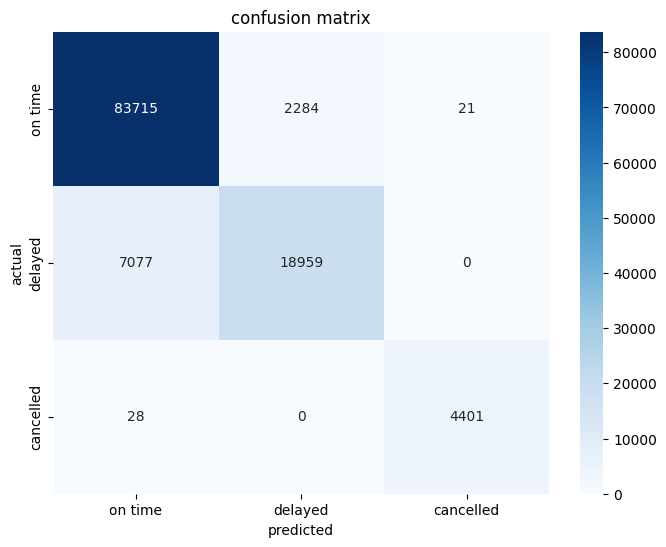

In [103]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['on time', 'delayed', 'cancelled'],
            yticklabels=['on time', 'delayed', 'cancelled'])
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("confusion matrix")
plt.show()

address class imbalances by generating synthetic samples for delayed and cancelled flights

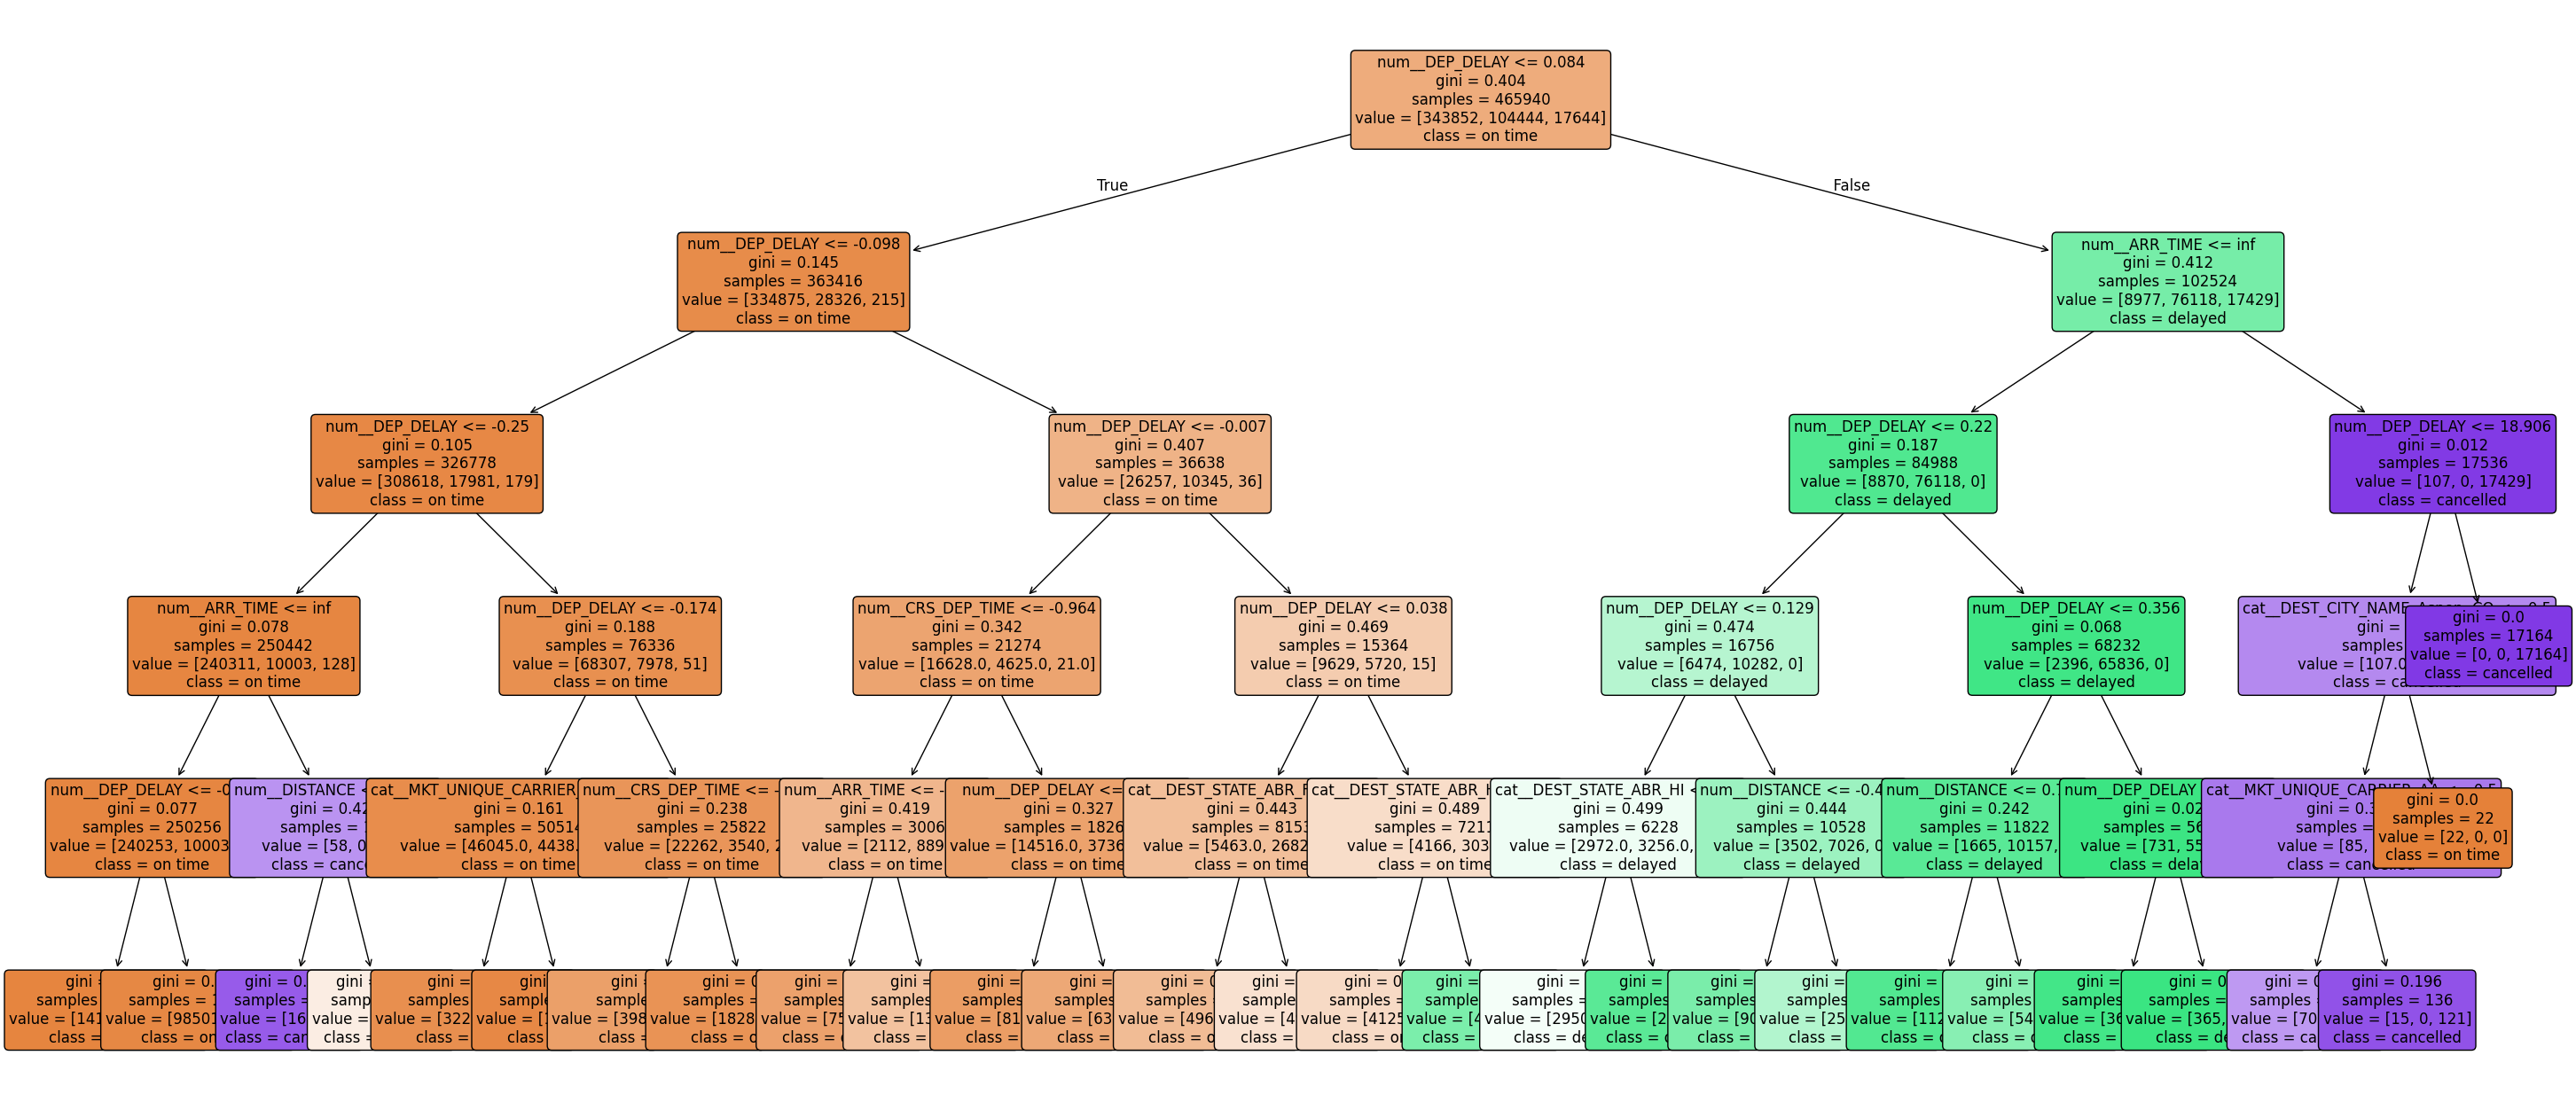

In [112]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

feature_names = model.named_steps['preprocessor'].get_feature_names_out()

plt.figure(figsize=(36, 16))
plot_tree(model.named_steps['classifier'],
          feature_names=feature_names,
          class_names=['on time', 'delayed', 'cancelled'],
          filled=True,
          rounded=True,
          fontsize=12)
plt.show()